In [1]:
# Cell 1: Setup - ALWAYS DO THIS FIRST
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfuly!")
print(f"Pandas version: {pd.__version__}")
print(f"Today's date: {datetime.now().strftime('%Y-%m-%d')}")

# Setting display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')


All libraries imported successfuly!
Pandas version: 2.3.3
Today's date: 2026-01-01


In [2]:
# Cell 2: Create Realistic Weather Data
def create_weather_data(start_date='2020-01-01', end_date='2023-12-31', location='Atlanta'):
    """
    Create synthetic weather data that mimics real patterns.

    Why synthetic first?
    1. Test pipeline works before getting real data
    2. No API limits or download issues
    3. I control all variables for learning
    """

    # Create date range (one row per day)
    dates = pd.date_range(start_date, end_date, freq='D')
    n_days = len(dates)

    print(f"Creating {n_days} days of weather data for {location}...")

    # Location-specific base temperatures
    location_params = {
        'Atlanta': {'base_temp': 15, 'annual_range': 25, 'summer_months': [6, 7, 8]},
        'Phoenix': {'base_temp': 20, 'annual_range': 30, 'summer_months': [5, 6, 7, 8, 9]},
        'Seattle': {'base_temp': 10, 'annual_range': 15, 'summer_months': [7, 8]}
    }

    params = location_params.get(location, location_params['Atlanta'])

    # Seasonal pattern (sine wave)
    seasonal = params['annual_range'] * np.sin(2 * np.pi * (dates.dayofyear - 105) / 365)


    # Climate change trend: warming over time
    # 0.02 degrees Celsius per year increase
    years_passed = (dates - dates[0]).days / 365.25
    trend = 0.02 * years_passed

    # Random daily variations
    noise = np.random.normal(0, 3, n_days) # Mean=0, Std=3

    # Combine: Base (15 degrees Celsius) + Seasonal + Trend + Noise
    mean_temp = params['base_temp'] + seasonal + trend + noise

    # Realistic Temperature Ranges
    # Daily temperature swing: typically 8-15°C difference between min and max
    daily_swing = np.random.uniform(8, 15, n_days) # More realistic than exponential

    # Create min/max with correlation to mean_temp
    # Max and Min temp are usually 4-8°C above and below daily mean
    temp_max = mean_temp + np.random.uniform(4, 8, n_days) + np.random.normal(0, 2, n_days)
    temp_min = mean_temp - np.random.uniform(4, 8, n_days) + np.random.normal(0, 2, n_days)

    # Ensure min < max
    for i in range(n_days):
        if temp_min[i] > temp_max[i]:
            temp_min[i], temp_max[i] = temp_max[i], temp_min[i]

    # Ensure realistic absolute limits for Atlanta
    # Summer highs rarely exceed 38°C, winter lows rarely below -10°C
    temp_max = np.clip(temp_max, -5, 38) # Clip unrealistic extremes
    temp_min = np.clip(temp_min, -15, 25)

    # Humidity: higher in summer, lower in winter
    base_humidity = 60 + 20 * np.sin(2 * np.pi * dates.dayofyear / 365)
    humidity = base_humidity + np.random.normal(0, 15, n_days)
    humidity = np.clip(humidity, 20, 100) # Keep between 20-100%

    # Precipitation: more in spring, less in winter
    base_precip_chance = 0.3 + 0.2 * np.sin(2 * np.pi * (dates.dayofyear - 90) / 365)
    precip_occurs = np.random.random(n_days) < base_precip_chance
    precipitation = precip_occurs * np.random.exponential(5, n_days)

    # Create DataFrame
    df = pd.DataFrame({
        'date': dates,
        'location': location,
        'temp_mean': mean_temp,
        'temp_max': temp_max,
        'temp_min': temp_min,
        'humidity': humidity,
        'precipitation': precipitation,
    })

    # Calculate "feels like" temperature (heat index)
    df['heat_index'] = calculate_heat_index(df['temp_mean'], df['humidity'])

    return df

def calculate_heat_index(temp_c, humidity):
    """
    Heat Index = what temperature FEELS LIKE to humans
    More accurate heat index calculation with bounds
    """
    # Convert to Fahrenheit (US formula)
    temp_f = temp_c * 9/5 + 32

    # Initialize result array
    result = np.zeros_like(temp_f)

    # Only calculate for temperatures above 80°F (26.7°C)
    mask = temp_f >= 80

    # Simplified Rothfusz regression
    T = temp_f[mask]
    RH = humidity[mask]

    hi = -42.379 + 2.04901523*T + 10.14333127*RH
    hi -= 0.22475541*T*RH - 0.00683783*T**2
    hi -= 0.05481717*RH**2 + 0.00122874*T**2*RH
    hi += 0.00085282*T*RH**2 - 0.00000199*T**2*RH**2

    # Adjustments for very high humidity
    adjustment = np.where((RH > 85) & (T >= 80) & (T <= 87),
                          ((RH - 85) / 10) * ((87 - T) / 5),
                          0)
    hi += adjustment

    # For temperatures below 80°F, heat index = temperature
    result[mask] = hi
    result[~mask] = temp_f[~mask]

    # Convert back to Celsius
    return (result - 32) * 5/9

# Generate data
print("Generating weather data...")
weather_df = create_weather_data(location='Atlanta')

# Show statistics
print("\n Weather statistics:")
print(f"Shape: {weather_df.shape} (rows, columns)")
print(f"Date range: {weather_df['date'].min().date()} to {weather_df['date'].max().date()}")
print(f"Average temperature: {weather_df['temp_mean'].mean():.1f}°C")
print(f"Hottest day: {weather_df['temp_max'].max():.1f}°C")
print(f"Coldest day: {weather_df['temp_min'].min():.1f}°C")
print(f"Typical daily swing: {(weather_df['temp_max'] - weather_df['temp_min']).mean():.1f}°C")
print(f"Rainy days: {(weather_df['precipitation'] > 0).sum()} out of {len(weather_df)}")

# Show sample
print("\n First 5 rows:")
print(weather_df.head().to_string(index=False))

# Show seasonal statistics
print("\n Seasonal Averages:")
weather_df['month'] = weather_df['date'].dt.month
seasonal_stats = weather_df.groupby('month').agg({
    'temp_mean': 'mean',
    'temp_max': 'mean',
    'temp_min': 'mean',
    'precipitation': 'sum'
}).round(1)

print(seasonal_stats)



Generating weather data...
Creating 1461 days of weather data for Atlanta...

 Weather statistics:
Shape: (1461, 8) (rows, columns)
Date range: 2020-01-01 to 2023-12-31
Average temperature: 15.1°C
Hottest day: 38.0°C
Coldest day: -15.0°C
Typical daily swing: 12.1°C
Rainy days: 440 out of 1461

 First 5 rows:
      date location  temp_mean  temp_max   temp_min   humidity  precipitation  heat_index
2020-01-01  Atlanta -11.149293 -5.000000 -15.000000  53.946475        0.00000  -11.149293
2020-01-02  Atlanta  -9.832093 -4.415085 -12.913002 100.000000        0.00000   -9.832093
2020-01-03  Atlanta -11.465447 -0.550132 -13.996801  89.185982        4.24234  -11.465447
2020-01-04  Atlanta -11.097161 -1.641847 -15.000000  65.205584        0.00000  -11.097161
2020-01-05  Atlanta -10.983745 -5.000000 -15.000000  70.607906        0.00000  -10.983745

 Seasonal Averages:
       temp_mean  temp_max  temp_min  precipitation
month                                              
1           -9.5      -2.

In [3]:
# Cell 3: Create Health Data - Simple
def create_health_data(weather_df):
    """
    Create health data correlated with heat
    """
    df = weather_df.copy()

    # Base ER visits
    base_visits = 50 # Just a number

    # Heat effect: if hot, more visits
    # Simple threshold: > 25°C = more visits
    heat_effect = np.where(df['temp_mean'] > 25, 20, 0)

    # Day of week: weekends fewer visits
    day_of_week = df['date'].dt.dayofweek
    weekend_effect = np.where(day_of_week >= 5, -15, 0)

    # Combine
    er_visits = base_visits + heat_effect + weekend_effect

    # Add some randomness
    er_visits = er_visits + np.random.normal(0, 5, len(df))

    # Make sure not negative
    er_visits = np.maximum(10, er_visits).astype(int)

    # Add to dataframe
    df['er_visits'] = er_visits

    # Simple mortality (rare)
    df['mortality_risk'] = np.where(df['temp_mean'] > 30, 0.1, 0.02)

    print("Health data created!")
    print(f" Average ER visits: {df['er_visits'].mean():.1f}")
    print(f" Hot days (>25°C): {(df['temp_mean'] > 25).sum()} days")
    print(f" ER visits on hot days: {df[df['temp_mean'] > 25]['er_visits'].mean():.1f}")

    return df

# Generate health data
print("Creating health data...")
combined_df = create_health_data(weather_df)

# Show sample
print("\n Sample (first 5 days):")
sample_cols = ['date', 'temp_mean', 'er_visits', 'mortality_risk']
print(combined_df[sample_cols].head().to_string(index=False))

# Quick check
print(f"\n Simple analysis:")
print(f" Correlation (temp vs ER visits): {combined_df['temp_mean'].corr(combined_df['er_visits']):.3f}")
print(" (Positive = hotter --> more visits, Negative = hotter --> fewer visits)")
print(" Should be positive for heat-health relationship!")

Creating health data...
Health data created!
 Average ER visits: 52.5
 Hot days (>25°C): 530 days
 ER visits on hot days: 65.6

 Sample (first 5 days):
      date  temp_mean  er_visits  mortality_risk
2020-01-01 -11.149293         38            0.02
2020-01-02  -9.832093         54            0.02
2020-01-03 -11.465447         48            0.02
2020-01-04 -11.097161         45            0.02
2020-01-05 -10.983745         26            0.02

 Simple analysis:
 Correlation (temp vs ER visits): 0.635
 (Positive = hotter --> more visits, Negative = hotter --> fewer visits)
 Should be positive for heat-health relationship!


Creating visualizations...


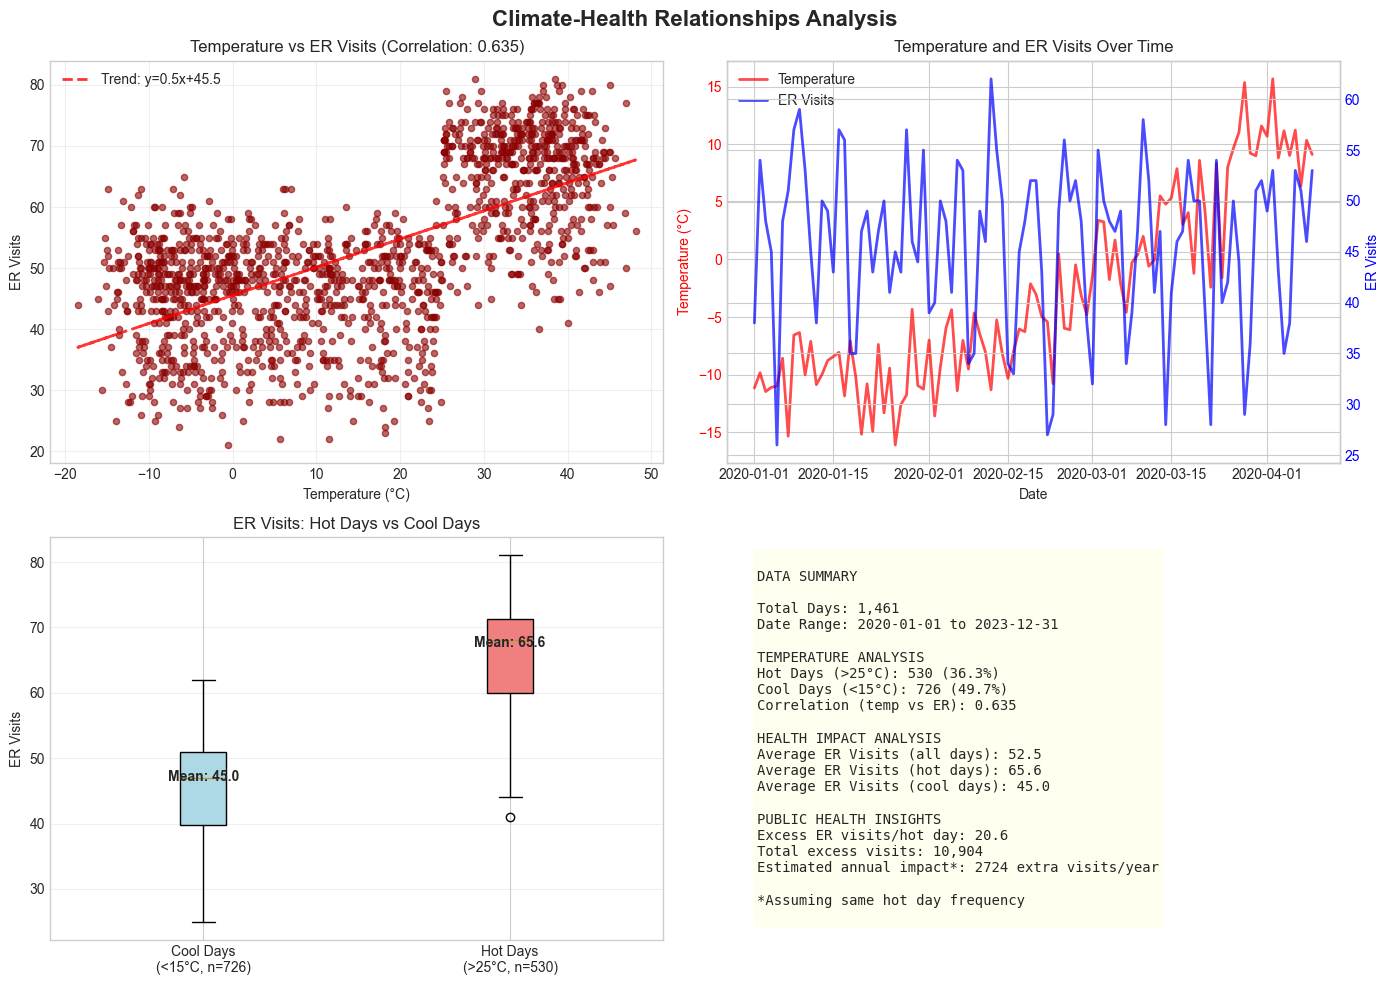

Visualizations created!
Saved to: data/climate_health_analysis.png

 NEXT: Cell 5 - Save data and prepare for Machine Learning!


In [4]:
# Cell 4: Create Visualizations - See Results!
import matplotlib.pyplot as plt
import seaborn as sns

print("Creating visualizations...")

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Climate-Health Relationships Analysis', fontsize=16, fontweight='bold')

# Plot 1: Scatter plot - Temperature vs ER Visits
axes[0, 0].scatter(combined_df['temp_mean'], combined_df['er_visits'],
                    alpha=0.6, s=20, color='darkred')
axes[0, 0].set_xlabel('Temperature (°C)')
axes[0, 0].set_ylabel('ER Visits')
axes[0,0].set_title(f'Temperature vs ER Visits (Correlation: {combined_df["temp_mean"].corr(combined_df["er_visits"]):.3f})')
axes[0, 0].grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(combined_df['temp_mean'], combined_df['er_visits'], 1)
p = np.poly1d(z)
axes[0, 0].plot(combined_df['temp_mean'], p(combined_df['temp_mean']),
                "r--", alpha=0.8, linewidth=2, label=f'Trend: y={z[0]:.1f}x+{z[1]:.1f}')
axes[0, 0].legend()

# Plot 2: Time Series (first 100 days for clarity)
sample_size = 100
dates_sample = combined_df['date'].iloc[:sample_size]
temp_sample = combined_df['temp_mean'].iloc[:sample_size]
er_sample = combined_df['er_visits'].iloc[:sample_size]

# Temperature line
axes[0, 1].plot(dates_sample, temp_sample, 'r-', label='Temperature', linewidth=2, alpha=0.7)
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Temperature (°C)', color='red')
axes[0, 1].tick_params(axis='y', labelcolor='red')

# ER visits on second y-axis
ax2 = axes[0, 1].twinx()
ax2.plot(dates_sample, er_sample, 'b-', label='ER Visits', linewidth=2, alpha=0.7)
ax2.set_ylabel('ER Visits', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

axes[0, 1].set_title('Temperature and ER Visits Over Time')
# Combine legends
lines1, labels1 = axes[0, 1].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
axes[0, 1].legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Plot 3: Hot vs Cool Days Comparison
# Define "hot" as > 25°C, "cool" as < 15°C
hot_days = combined_df[combined_df['temp_mean'] > 25]
cool_days = combined_df[combined_df['temp_mean'] < 15]

# Prepare data for boxplot
data_to_plot = [
    cool_days['er_visits'].values[:200], # Limit for clarity
    hot_days['er_visits'].values[:200]
]
labels = [f'Cool Days\n(<15°C, n={len(cool_days)})',
          f'Hot Days\n(>25°C, n={len(hot_days)})']

box = axes[1, 0].boxplot(data_to_plot, labels=labels, patch_artist=True)
# Color the boxes
colors = ['lightblue', 'lightcoral']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

axes[1, 0].set_ylabel('ER Visits')
axes[1,0].set_title('ER Visits: Hot Days vs Cool Days')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Add mean values
for i, data in enumerate(data_to_plot, 1):
    mean_val = np.mean(data)
    axes[1, 0].text(i, mean_val + 1, f'Mean: {mean_val:.1f}',
                    ha='center', va='bottom', fontweight='bold')

# Plot 4: Summary Statistics
axes[1, 1].axis('off') # Turn offfor text

# Calculate key statistics
total_days = len(combined_df)
hot_day_count = len(hot_days)
cool_day_count = len(cool_days)
avg_er_all = combined_df['er_visits'].mean()
avg_er_hot = hot_days['er_visits'].mean()
avg_er_cool = cool_days['er_visits'].mean()
excess_per_hot_day = avg_er_hot - avg_er_cool
total_excess_visits = excess_per_hot_day * hot_day_count

# Create summary text
summary_text = f"""
DATA SUMMARY

Total Days: {total_days:,}
Date Range: {combined_df['date'].min().date()} to {combined_df['date'].max().date()}

TEMPERATURE ANALYSIS
Hot Days (>25°C): {hot_day_count:,} ({hot_day_count/total_days*100:.1f}%)
Cool Days (<15°C): {cool_day_count:,} ({cool_day_count/total_days*100:.1f}%)
Correlation (temp vs ER): {combined_df['temp_mean'].corr(combined_df['er_visits']):.3f}

HEALTH IMPACT ANALYSIS
Average ER Visits (all days): {avg_er_all:.1f}
Average ER Visits (hot days): {avg_er_hot:.1f}
Average ER Visits (cool days): {avg_er_cool:.1f}

PUBLIC HEALTH INSIGHTS
Excess ER visits/hot day: {excess_per_hot_day:.1f}
Total excess visits: {total_excess_visits:,.0f}
Estimated annual impact*: {excess_per_hot_day * (hot_day_count/len(combined_df)*365):.0f} extra visits/year

*Assuming same hot day frequency
"""

axes[1, 1].text(0.05, 0.5, summary_text, fontfamily='monospace',
                fontsize=10, verticalalignment='center',
                bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5))

# Adjust layout and save
plt.tight_layout()

# Save the figure
plt.savefig('../data/climate_health_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("Visualizations created!")
print("Saved to: data/climate_health_analysis.png")
print("\n NEXT: Cell 5 - Save data and prepare for Machine Learning!")

In [5]:
# Cell 5: Save Data and Prepare for Machine Learning (ML)
import os
print("Saving data and preparing for Machine Learning (ML)...")
print("=" * 60)
# First, see what I have
print("\n CURRENT DATASET SHAPE:")
print(f" Rows: {combined_df.shape[0]:,}")
print(f" Columns: {combined_df.shape[1]}")
print(f" Columns: {list(combined_df.columns)}")

# Second, save the combined dataset
save_path = '../data/combined_weather_health.csv'
combined_df.to_csv(save_path, index=False)
print(f"\n Saved to: {save_path}")
print(f" File created: {os.path.exists(save_path)}")

# Third, create features for ML (Feature Engineering)
print("\n CREATING ML FEATURES (Feature Engineering)...")

def create_ml_features(df):
    """
    Create features for time-series prediction.
    """
    df = df.copy()

    print(" 1. Creating time-based features...")
    # Day of year (seasonality)
    df['day_of_year'] = df['date'].dt.dayofyear
    # Month
    df['month'] = df['date'].dt.month
    # Day of week (0=Monday, 6=Sunday)
    df['day_of_week'] = df['date'].dt.dayofweek
    # Weekend indicator
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

    print(" 2. Creating lag features (yesterday's weather matters)...")
    # Yesterday's temperature affects today's health
    df['temp_yesterday'] = df['temp_mean'].shift(1)
    df['temp_2days_ago'] = df['temp_mean'].shift(2)
    df['temp_3days_ago'] = df['temp_mean'].shift(3)

    print(" 3. Creating rolling averages (3-day trends)...")
    # 3-day average temperature
    df['temp_3day_avg'] = df['temp_mean'].rolling(window=3).mean()
    # 7-day average temperature
    df['temp_7day_avg'] = df['temp_mean'].rolling(window=7).mean()

    print(" 4. Creating heat indicators...")
    # Hot day indicator
    df['is_hot_day'] = (df['temp_mean'] > 25).astype(int)
    # Very hot day indicator
    df['is_very_hot'] = (df['temp_mean'] > 30).astype(int)

    print(" 5. Creating heatwave indicator...")
    # Heatwave = 3+ consecutive hot days
    df['hot_streak'] = df['is_hot_day'].groupby((df['is_hot_day'] != df['is_hot_day'].shift()).cumsum()).cumsum()
    df['heatwave'] = (df['hot_streak'] >= 3).astype(int)

    print(" 6. Creating target variable (what we want to predict)...")
    # Predict TOMORROW'S ER visits using TODAY'S weather
    df['target'] = df['er_visits'].shift(-1)

    print(" 7. Removing rows with missing values...")
    # Drop rows with NaN (from shifting operations)
    df_clean = df.dropna().copy()

    print(f" Before cleaning: {len(df)} rows")
    print(f" After cleaning: {len(df_clean)} rows")

    return df_clean

# Apply feature engineering
ml_df = create_ml_features(combined_df)

# 4. Show what I created
print("\n ML-READY DATASET:")
print(f" Final shape: {ml_df.shape[0]:,} rows x {ml_df.shape[1]} columns")
print(f" Date range: {ml_df['date'].min().date()} to {ml_df['date'].max().date()}")

print("\n SAMPLE OF NEW FEATURES (first 5 days):")
sample_features = ['date', 'temp_mean', 'temp_yesterday', 'temp_3day_avg',
                    'is_hot_day', 'heatwave', 'target']
print(ml_df[sample_features].head().round(2).to_string(index=False))

# 5. Save ML-ready dataset
ml_save_path = '../data/ml_ready_dataset.csv'
ml_df.to_csv(ml_save_path, index=False)
print(f"/n ML-ready data saved to: {ml_save_path}")

# 6. Quick analysis of features
print("\n FEATURE ANALYSIS:")
print(" Feature                | Correlation with Target")
print("  " + "-" * 55)

# Calculate correlation of each feature with target
features_to_check = ['temp_mean', 'temp_yesterday', 'temp_3day_avg',
                    'is_hot_day', 'heatwave', 'day_of_week', 'is_weekend']

for feature in features_to_check:
    if feature in ml_df.columns:
        corr = ml_df[feature].corr(ml_df['target'])
        stars = "***" if abs(corr) > 0.3 else "**" if abs(corr) > 0.2 else "*"
        print(f"  {feature:25s} | {corr:6.3f} {stars}")

print("\n INTERPRETATION:")
print("  *** = Strong predictor (>0.3)")
print("  ** = Moderate predictor (>0.2)")
print("  *  = Weak predictor")
print("  Negative values = inverse relationship")

# 7. Final summary
print("\n" + "=" * 60)
print(" CELL 5 COMPLETE - READY FOR MACHINE LEARNING!")
print("=" * 60)
print(f"\n Files created:")
print(f" 1. {save_path} - Raw combined data")
print(f" 2. {ml_save_path} - ML-ready features")
print(f" 3. ../data/climate_health_analysis.png - Visualizations")

print("\n NEXT STEPS:")
print(" 1. Create new notebook: 02_machine_learning.ipynb")
print(" 2. Load ml_ready_dataset.csv")
print(" 3. Train ML models to predict ER visits!")
print("\n DATA PIPELINE IS COMPLETE!")

Saving data and preparing for Machine Learning (ML)...

 CURRENT DATASET SHAPE:
 Rows: 1,461
 Columns: 11
 Columns: ['date', 'location', 'temp_mean', 'temp_max', 'temp_min', 'humidity', 'precipitation', 'heat_index', 'month', 'er_visits', 'mortality_risk']

 Saved to: ../data/combined_weather_health.csv
 File created: True

 CREATING ML FEATURES (Feature Engineering)...
 1. Creating time-based features...
 2. Creating lag features (yesterday's weather matters)...
 3. Creating rolling averages (3-day trends)...
 4. Creating heat indicators...
 5. Creating heatwave indicator...
 6. Creating target variable (what we want to predict)...
 7. Removing rows with missing values...
 Before cleaning: 1461 rows
 After cleaning: 1454 rows

 ML-READY DATASET:
 Final shape: 1,454 rows x 24 columns
 Date range: 2020-01-07 to 2023-12-30

 SAMPLE OF NEW FEATURES (first 5 days):
      date  temp_mean  temp_yesterday  temp_3day_avg  is_hot_day  heatwave  target
2020-01-07     -15.34           -8.57      